# Setup

In [1]:
import os
import sys
import torch
import torchvision
import torchvision.transforms as transforms
import einops

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

if "x-perceiver" not in os.listdir(): 
    os.chdir("/Users/konsti/Documents/repos/phd/x-perceiver/")
    
%reload_ext autoreload
%autoreload 2

## Simple perceiver vision model

In [74]:
from torch.utils.data import DataLoader
from typing import *

CLASSES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
SEED = 42
BATCH_SIZE=4

def load_cifar(batch_size: int, pin_memory: bool=False, num_workers:int=4) -> Tuple[DataLoader]: 
    """
    Loads and transforms cifar dataset
    """
    cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=cifar_transform)
    cifar_trainloader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers, pin_memory=True)

    cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=cifar_transform)
    cifar_testloader = torch.utils.data.DataLoader(cifar_test, batch_size=batch_size,
                                             shuffle=False, num_workers=num_workers, pin_memory=True)
    return cifar_trainloader, cifar_testloader

# load cifar_train
cifar_trainloader, cifar_testloader = load_cifar(batch_size=4, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


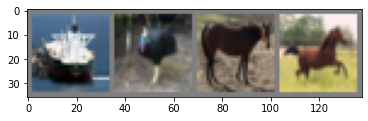

ship  bird  horse horse


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(cifar_trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))

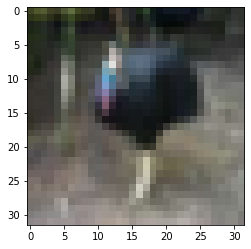

In [4]:
from einops import rearrange, reduce, repeat

img = images[1]
imshow(img)
# add axis
def preprocess_cifar(img) -> torch.Tensor: 
    """
    Reshapes torch tensors from CIFAR format (c h w) to 
    required format for Perceiver: b h w c
    Note that if batch_size=None, the standard b will be set to one, 
    such that the format is always bhwc
    If batch of images is passed in, the size of the batch is preserved
    """
    
    # introduce relevant batch dim
    if len(list(img.size())) == 3: 
        # introduce batch dim if not given
        img = repeat(img, 'c h w -> b c h w', b=1)
    
    # rearrange for perceiver (bhwc)
    img_new = rearrange(img, 'b c h w -> b h w c')

    return img_new

img_new = preprocess_cifar(img)

In [5]:
from x_perceiver.perceiver import Perceiver
from torchsummary import summary

In [6]:
image_perceiver = Perceiver( 
    input_channels=3, 
    input_axis=2, 
    num_freq_bands=6, 
    depth=1, # number of cross-attention iterations 
    max_freq=10., 
)

In [7]:
# check model size
summary(image_perceiver, (32, 32, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1             [-1, 512, 512]           1,024
         LayerNorm-2             [-1, 1024, 29]              58
            Linear-3              [-1, 512, 64]          32,768
            Linear-4            [-1, 1024, 128]           3,712
           Dropout-5            [-1, 512, 1024]               0
            Linear-6             [-1, 512, 512]          33,280
         Attention-7             [-1, 512, 512]               0
           PreNorm-8             [-1, 512, 512]               0
         LayerNorm-9             [-1, 512, 512]           1,024
           Linear-10            [-1, 512, 4096]       2,101,248
            GEGLU-11            [-1, 512, 2048]               0
           Linear-12             [-1, 512, 512]       1,049,088
          Dropout-13             [-1, 512, 512]               0
      FeedForward-14             [-1, 5

In [8]:
# simple CNN as baseline
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
summary(conv_net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [ ]:
subl Library/Jupyter/nbextensions/snippets/snippets.json

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# enable Mac MPS backend
torch.cuda.is_available()

False

### TODO 

- training loop implementation: https://github.com/krasserm/perceiver-io
- performance tuning guide: https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html

In [29]:
# Implement train loop 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from typing import *
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


def train_loop(
    preprocess_fn: Callable, 
    model: nn.Module, 
    trainloader: torch.utils.data.DataLoader,
    testloader: torch.utils.data.DataLoader,
    epochs: int=1, 
#     convnet: bool = True
) -> None: 
    
    
    lr = 0.005
    momentum = 0.9

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    # set efficient OneCycle scheduler, significantly reduces required training iters
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=0.05, epochs=epochs, steps_per_epoch=len(trainloader))
#     scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate,verbose=True)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(tqdm(trainloader)):

            inputs, labels = data
            if preprocess_fn is not None: 
                inputs = preprocess_fn(inputs)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                print(f'[Epoch {epoch + 1}, Batch {i + 1:5d}] train_loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
    print('Finished Training')
    accuracy, f1, precision, recall = evaluate(model, testloader)
    print(f"accuracy: {accuracy:.4f}, f1: {f1:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")

    
def evaluate(model: nn.Module, data_loader: torch.utils.data.DataLoader):
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for batch in data_loader:
            inputs, labels = batch
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
    
    # resume train mode
    model.train()
    return accuracy, f1, precision, recall


In [32]:
cifar_trainloader, cifar_testloader = load_cifar(batch_size=64, pin_memory=True)
# TRAIN PERCEIVER
image_perceiver = Perceiver(
    input_channels=3, 
    input_axis=2, 
    num_freq_bands=6, 
    depth=1, # number of cross-attention iterations 
    max_freq=10., 
)
# train_loop(preprocess_fn=preprocess_cifar, model=image_perceiver, trainloader=cifar_trainloader, testloader=cifar_testloader)

# TRAIN CONV NET
# conv_net = ConvNet() # re-initialise each time
# train_loop(model=conv_net, trainloader=cifar_trainloader, testloader=cifar_testloader, preprocess_fn=None, epochs=20)

Files already downloaded and verified
Files already downloaded and verified


[Epoch 1, Batch   100] train_loss: 0.115
[Epoch 1, Batch   200] train_loss: 0.115
[Epoch 1, Batch   300] train_loss: 0.114
[Epoch 1, Batch   400] train_loss: 0.110
[Epoch 1, Batch   500] train_loss: 0.099
[Epoch 1, Batch   600] train_loss: 0.091
[Epoch 1, Batch   700] train_loss: 0.087



[Epoch 2, Batch   100] train_loss: 0.082
[Epoch 2, Batch   200] train_loss: 0.079
[Epoch 2, Batch   300] train_loss: 0.079
[Epoch 2, Batch   400] train_loss: 0.076
[Epoch 2, Batch   500] train_loss: 0.074
[Epoch 2, Batch   600] train_loss: 0.073
[Epoch 2, Batch   700] train_loss: 0.073



[Epoch 3, Batch   100] train_loss: 0.071
[Epoch 3, Batch   200] train_loss: 0.069
[Epoch 3, Batch   300] train_loss: 0.068
[Epoch 3, Batch   400] train_loss: 0.068
[Epoch 3, Batch   500] train_loss: 0.067
[Epoch 3, Batch   600] train_loss: 0.067
[Epoch 3, Batch   700] train_loss: 0.068



[Epoch 4, Batch   100] train_loss: 0.063
[Epoch 4, Batch   200] train_loss: 0.065
[Epoch 4, Batch   300] train_loss: 0.064
[Epoch 4, Batch   400] train_loss: 0.064
[Epoch 4, Batch   500] train_loss: 0.064
[Epoch 4, Batch   600] train_loss: 0.064
[Epoch 4, Batch   700] train_loss: 0.065



[Epoch 5, Batch   100] train_loss: 0.062
[Epoch 5, Batch   200] train_loss: 0.060
[Epoch 5, Batch   300] train_loss: 0.062
[Epoch 5, Batch   400] train_loss: 0.061
[Epoch 5, Batch   500] train_loss: 0.061
[Epoch 5, Batch   600] train_loss: 0.063
[Epoch 5, Batch   700] train_loss: 0.062



[Epoch 6, Batch   100] train_loss: 0.057
[Epoch 6, Batch   200] train_loss: 0.058
[Epoch 6, Batch   300] train_loss: 0.059
[Epoch 6, Batch   400] train_loss: 0.060
[Epoch 6, Batch   500] train_loss: 0.058
[Epoch 6, Batch   600] train_loss: 0.061
[Epoch 6, Batch   700] train_loss: 0.059



[Epoch 7, Batch   100] train_loss: 0.054
[Epoch 7, Batch   200] train_loss: 0.056
[Epoch 7, Batch   300] train_loss: 0.058
[Epoch 7, Batch   400] train_loss: 0.059
[Epoch 7, Batch   500] train_loss: 0.059
[Epoch 7, Batch   600] train_loss: 0.057
[Epoch 7, Batch   700] train_loss: 0.059



[Epoch 8, Batch   100] train_loss: 0.055
[Epoch 8, Batch   200] train_loss: 0.054
[Epoch 8, Batch   300] train_loss: 0.055
[Epoch 8, Batch   400] train_loss: 0.056
[Epoch 8, Batch   500] train_loss: 0.056
[Epoch 8, Batch   600] train_loss: 0.056
[Epoch 8, Batch   700] train_loss: 0.056



[Epoch 9, Batch   100] train_loss: 0.052
[Epoch 9, Batch   200] train_loss: 0.054
[Epoch 9, Batch   300] train_loss: 0.054
[Epoch 9, Batch   400] train_loss: 0.054
[Epoch 9, Batch   500] train_loss: 0.056
[Epoch 9, Batch   600] train_loss: 0.054
[Epoch 9, Batch   700] train_loss: 0.054



[Epoch 10, Batch   100] train_loss: 0.052
[Epoch 10, Batch   200] train_loss: 0.051
[Epoch 10, Batch   300] train_loss: 0.051
[Epoch 10, Batch   400] train_loss: 0.054
[Epoch 10, Batch   500] train_loss: 0.052
[Epoch 10, Batch   600] train_loss: 0.055
[Epoch 10, Batch   700] train_loss: 0.053



[Epoch 11, Batch   100] train_loss: 0.048
[Epoch 11, Batch   200] train_loss: 0.050
[Epoch 11, Batch   300] train_loss: 0.050
[Epoch 11, Batch   400] train_loss: 0.050
[Epoch 11, Batch   500] train_loss: 0.052
[Epoch 11, Batch   600] train_loss: 0.052
[Epoch 11, Batch   700] train_loss: 0.052



[Epoch 12, Batch   100] train_loss: 0.047
[Epoch 12, Batch   200] train_loss: 0.049
[Epoch 12, Batch   300] train_loss: 0.049
[Epoch 12, Batch   400] train_loss: 0.048
[Epoch 12, Batch   500] train_loss: 0.050
[Epoch 12, Batch   600] train_loss: 0.050
[Epoch 12, Batch   700] train_loss: 0.051



[Epoch 13, Batch   100] train_loss: 0.043
[Epoch 13, Batch   200] train_loss: 0.045
[Epoch 13, Batch   300] train_loss: 0.046
[Epoch 13, Batch   400] train_loss: 0.047
[Epoch 13, Batch   500] train_loss: 0.047
[Epoch 13, Batch   600] train_loss: 0.046
[Epoch 13, Batch   700] train_loss: 0.046



[Epoch 14, Batch   100] train_loss: 0.042
[Epoch 14, Batch   200] train_loss: 0.041
[Epoch 14, Batch   300] train_loss: 0.044
[Epoch 14, Batch   400] train_loss: 0.044
[Epoch 14, Batch   500] train_loss: 0.044
[Epoch 14, Batch   600] train_loss: 0.043
[Epoch 14, Batch   700] train_loss: 0.044



[Epoch 15, Batch   100] train_loss: 0.038
[Epoch 15, Batch   200] train_loss: 0.039
[Epoch 15, Batch   300] train_loss: 0.038
[Epoch 15, Batch   400] train_loss: 0.040
[Epoch 15, Batch   500] train_loss: 0.040
[Epoch 15, Batch   600] train_loss: 0.040
[Epoch 15, Batch   700] train_loss: 0.041



[Epoch 16, Batch   100] train_loss: 0.035
[Epoch 16, Batch   200] train_loss: 0.035
[Epoch 16, Batch   300] train_loss: 0.035
[Epoch 16, Batch   400] train_loss: 0.035
[Epoch 16, Batch   500] train_loss: 0.036
[Epoch 16, Batch   600] train_loss: 0.035
[Epoch 16, Batch   700] train_loss: 0.036



[Epoch 17, Batch   100] train_loss: 0.030
[Epoch 17, Batch   200] train_loss: 0.031
[Epoch 17, Batch   300] train_loss: 0.030
[Epoch 17, Batch   400] train_loss: 0.030
[Epoch 17, Batch   500] train_loss: 0.031
[Epoch 17, Batch   600] train_loss: 0.030
[Epoch 17, Batch   700] train_loss: 0.031



[Epoch 18, Batch   100] train_loss: 0.024
[Epoch 18, Batch   200] train_loss: 0.025
[Epoch 18, Batch   300] train_loss: 0.024
[Epoch 18, Batch   400] train_loss: 0.025
[Epoch 18, Batch   500] train_loss: 0.025
[Epoch 18, Batch   600] train_loss: 0.025
[Epoch 18, Batch   700] train_loss: 0.026



[Epoch 19, Batch   100] train_loss: 0.021
[Epoch 19, Batch   200] train_loss: 0.021
[Epoch 19, Batch   300] train_loss: 0.021
[Epoch 19, Batch   400] train_loss: 0.020
[Epoch 19, Batch   500] train_loss: 0.021
[Epoch 19, Batch   600] train_loss: 0.021
[Epoch 19, Batch   700] train_loss: 0.022



[Epoch 20, Batch   100] train_loss: 0.020
[Epoch 20, Batch   200] train_loss: 0.018
[Epoch 20, Batch   300] train_loss: 0.019
[Epoch 20, Batch   400] train_loss: 0.018
[Epoch 20, Batch   500] train_loss: 0.019
[Epoch 20, Batch   600] train_loss: 0.019
[Epoch 20, Batch   700] train_loss: 0.018

Finished Training
accuracy: 0.6253, f1: 0.6253, precision: 0.6260, recall: 0.6253


## Tabular perceiver model

In [37]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [39]:
from torch.utils.data import Dataset

In [82]:
# class SklearnDataset(Dataset): 
#     """
#     Simple wrapper to load sklearn dataset as PyTorch dataset object
#     """
#     def __init__(self, load_fn): 
#         # load in data
#         self.data = load_fn()
        
#     def __len__(self):
#         return self.data["data"].shape[0]
    
#     def __getitem__(self, idx):
#         item = torch.Tensor(self.df["data"][idx])
#         # add batch dim to tensor
#         item = einops.repeat(item, 'feats -> b feats c', b=1, c=1)
#         label = self.data["target"][idx]
#         return item, label        

class SklearnDataset(Dataset): 
    
    def __init__(self, X: np.array, y: np.array): 
        self.X = X
        self.y = y
    
    def __len__(self): 
        return self.X.shape[0]

    def __getitem__(self, idx):
        item = torch.Tensor(self.X[idx])
        item = einops.repeat(item, 'feat -> b feat c', b=1, c=1) # can refactor to preprocessing function
        label = self.y[idx]
        return item, label        
    
    
def preprocess_tabular(sample): 
    pass

In [83]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

# wbc = SklearnDataset(load_breast_cancer)

In [84]:
BATCH_SIZE = 64
wbc_trainloader = DataLoader(dataset=SklearnDataset(X_train, y_train), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False
                         )

wbc_testloader = DataLoader(dataset=SklearnDataset(X_test, y_test), 
                            batch_size=BATCH_SIZE, 
                            shuffle=False
                           )

In [85]:
wbc_iter = iter(wbc_trainloader)
sample, label = next(wbc_iter)
print(sample.shape)

torch.Size([64, 1, 30, 1])


In [ ]:
tabular_perceiver = Perceiver( 
    input_channels=1, 
    input_axis=2, # second axis (b n_feats c)
    num_freq_bands=6, 
    depth=1, 
    max_freq=10., 
)
train_loop(preprocess_fn=None, model=tabular_perceiver, trainloader=wbc_trainloader, testloader=wbc_testloader, epochs=3)